In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

N_FOLDS = 5
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

In [3]:
X_train = pd.read_csv('X_train.csv', header=None)
X_train.columns = [f'f_{i}' for i in range(X_train.shape[1])]
y_train = pd.read_csv('y_train.csv', header=None).values.ravel()

X_test = pd.read_csv('X_test.csv', header=None)
X_test.columns = [f'f_{i}' for i in range(X_test.shape[1])]

# Наивно обучаем

Хоть нам и явно сказано, что "коробочные" решения не работают, попробовать стоит. Нам все равно может пригодиться карта важности признаков. С ее помощью замечаем, что $f_0, \dots, f_3$ совсем не влияют на предсказания и скорее всего являются шумом.

In [4]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

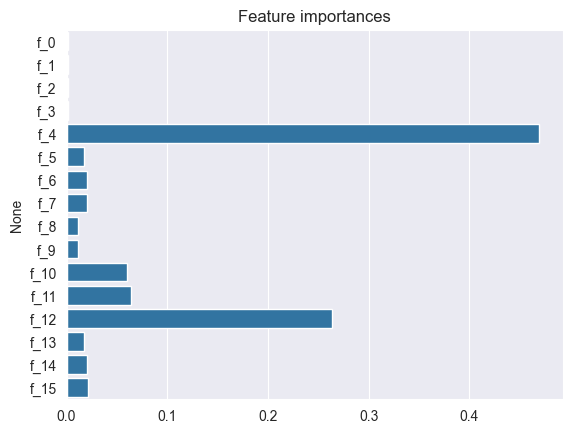

In [5]:
sns.barplot(x=model.feature_importances_, y=X_train.columns)
plt.title("Feature importances")
plt.show()

In [6]:
X_train.drop(columns=[f'f_{i}' for i in range(4)], inplace=True)
X_test.drop(columns=[f'f_{i}' for i in range(4)], inplace=True)

# Анализ через describe

После очистки шума мы не получаем ожидаемую метрику => продолжаем анализ. Посмотрев и оценив $X_{train}$ и $X_{test}$ с помощью метода describe, можно заметить, что некоторые признаки, а именно: $f_4, \dots, f_7$ по-разному распределены в выборках. А также можно сделать предположение о бинарности признаков $f_4$ и $f_{12}$

In [7]:
X_train.describe()

,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.499500,0.991275,3.492389,3.487816,1.002620,2.994680,4.500824,1.501175,0.499500,0.991275,3.492389,3.487816
std,0.500006,0.818209,2.016651,2.018964,0.574658,1.726063,2.594021,0.870372,0.500006,0.818209,2.016651,2.018964
min,0.000000,0.000000,0.000220,0.000100,0.000068,0.000015,0.000172,0.000113,0.000000,0.000000,0.000220,0.000100
25%,0.000000,0.000000,1.731510,1.733274,0.507572,1.499907,2.271650,0.743164,0.000000,0.000000,1.731510,1.733274
50%,0.000000,1.000000,3.502283,3.489752,1.004894,2.992040,4.492366,1.494108,0.000000,1.000000,3.502283,3.489752
75%,1.000000,2.000000,5.230650,5.243342,1.500862,4.475840,6.740416,2.260100,1.000000,2.000000,5.230650,5.243342
max,1.000000,2.000000,6.999947,6.999826,1.999868,5.999870,8.998587,2.999977,1.000000,2.000000,6.999947,6.999826


In [8]:
X_test.describe()

,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.098800,0.203400,0.682409,0.708991,0.991308,2.961085,4.489865,1.493634,0.497500,0.997000,3.490867,3.510709
std,0.298408,0.545397,1.646307,1.683894,0.575388,1.729284,2.598319,0.862045,0.500019,0.819792,2.024600,2.019105
min,0.000000,0.000000,0.000000,0.000000,0.000009,0.000580,0.001481,0.000317,0.000000,0.000000,0.000497,0.000102
25%,0.000000,0.000000,0.000000,0.000000,0.494377,1.456514,2.251439,0.757567,0.000000,0.000000,1.756188,1.778602
50%,0.000000,0.000000,0.000000,0.000000,0.988133,2.952605,4.464466,1.491469,0.000000,1.000000,3.483564,3.509484
75%,0.000000,0.000000,0.000000,0.000000,1.487121,4.439763,6.725501,2.228800,1.000000,2.000000,5.266116,5.268941
max,1.000000,2.000000,6.994935,6.997759,1.998901,5.999346,8.999873,2.999793,1.000000,2.000000,6.999759,6.999570


# Оценим распределения

Методом "пристального" разглядывания убеждаемся в отличности распределений ранее упомянутых признаков на тестовой и обучающей выборках. А они по "мнению" модели крайне важны => мы скамимся и ищем зависимость свойственную только обучающей выборке. Но что делать с этой информацией?

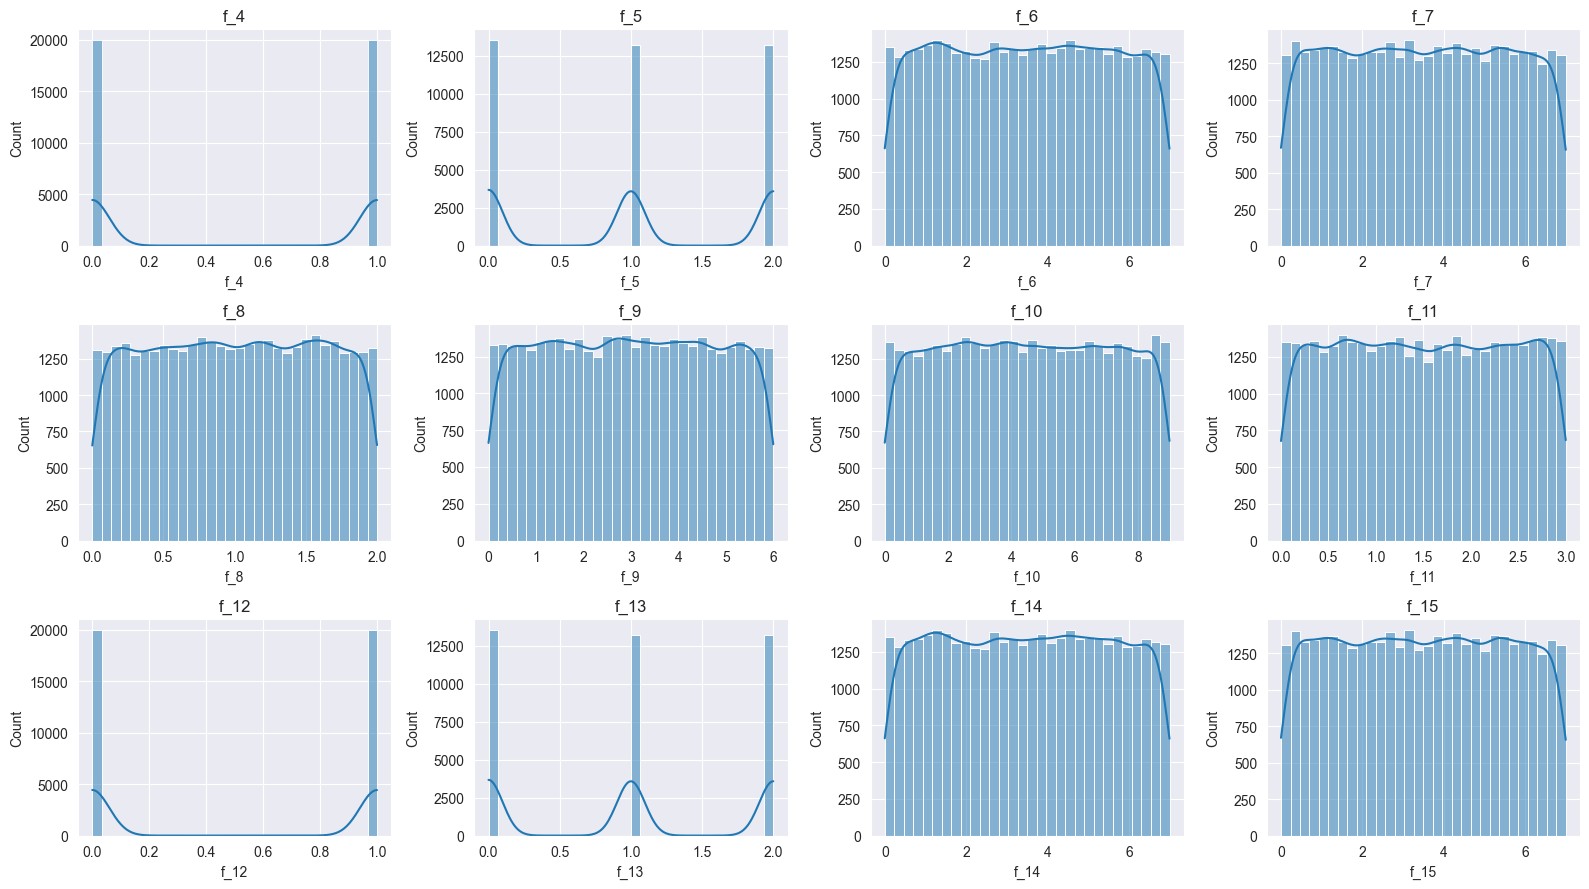

In [9]:
cols_per_row = 4
num_rows = (X_train.shape[1] + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 4, num_rows * 3))

for i, col in enumerate(X_train.columns):
    plt.subplot(num_rows, cols_per_row, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(col)
    plt.tight_layout()

plt.show()

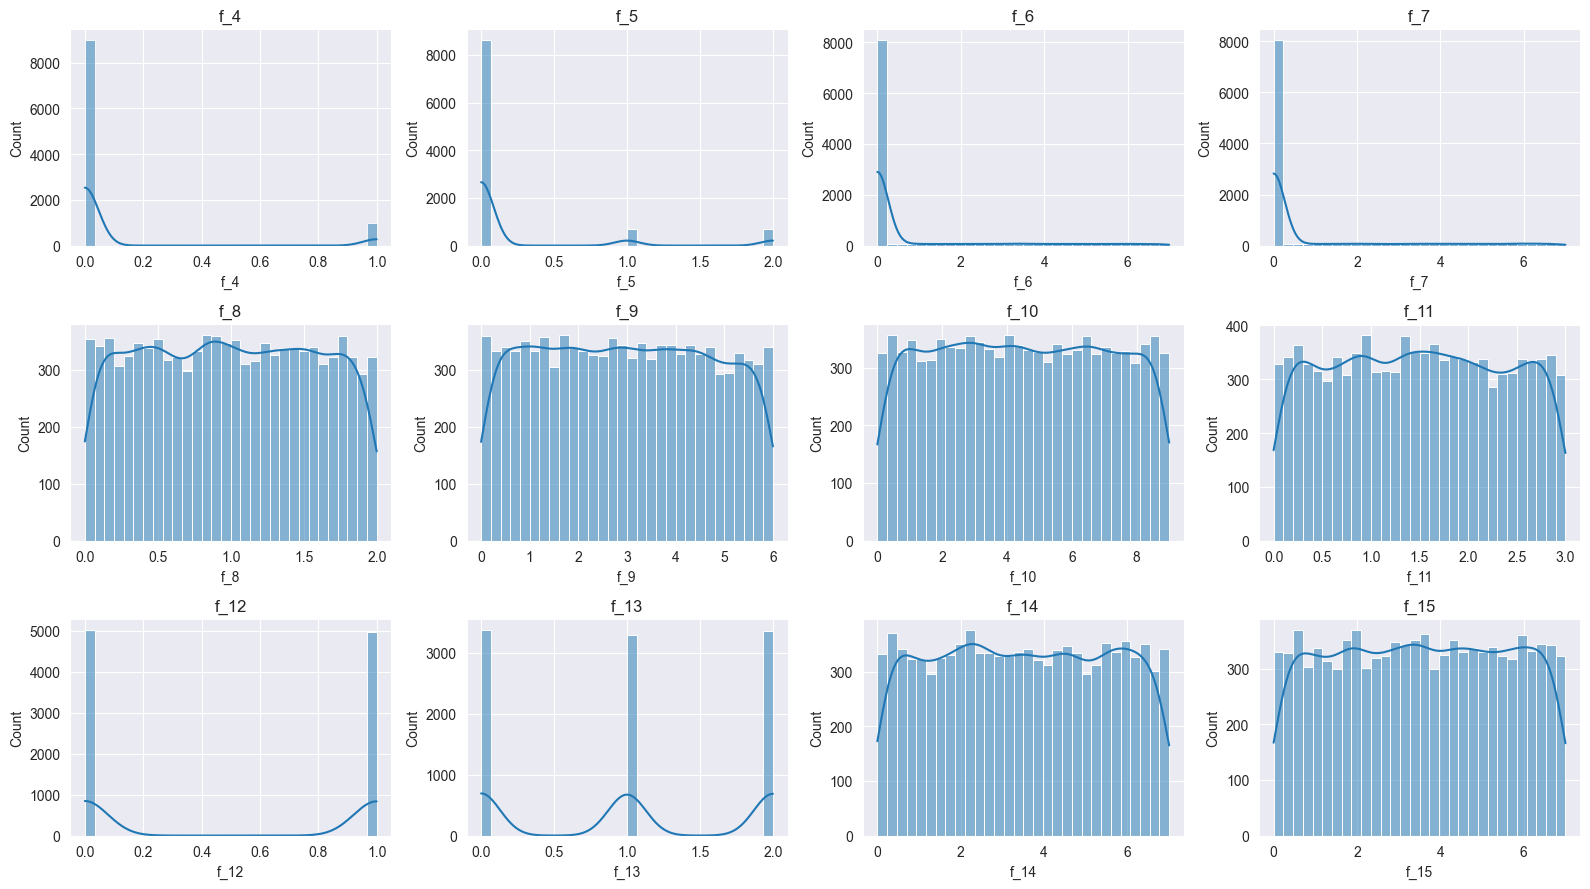

In [10]:
cols_per_row = 4
num_rows = (X_test.shape[1] + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 4, num_rows * 3))

for i, col in enumerate(X_test.columns):
    plt.subplot(num_rows, cols_per_row, i + 1)
    sns.histplot(X_test[col], kde=True, bins=30)
    plt.title(col)
    plt.tight_layout()

plt.show()

# Оценим корреляцию признаков

Построение тепловой карты корреляции дает нам информацию о прямой корреляции признаков $f_{i}$ и $f_{i + 8}$  для $i$ начиная с 4. Из-за такой корреляции и данных о распределении делаем вывод, что признаки $f_4, \dots, f_7$ скорее всего являются "импостерами" и добавлены только чтобы сбить модель с толку.

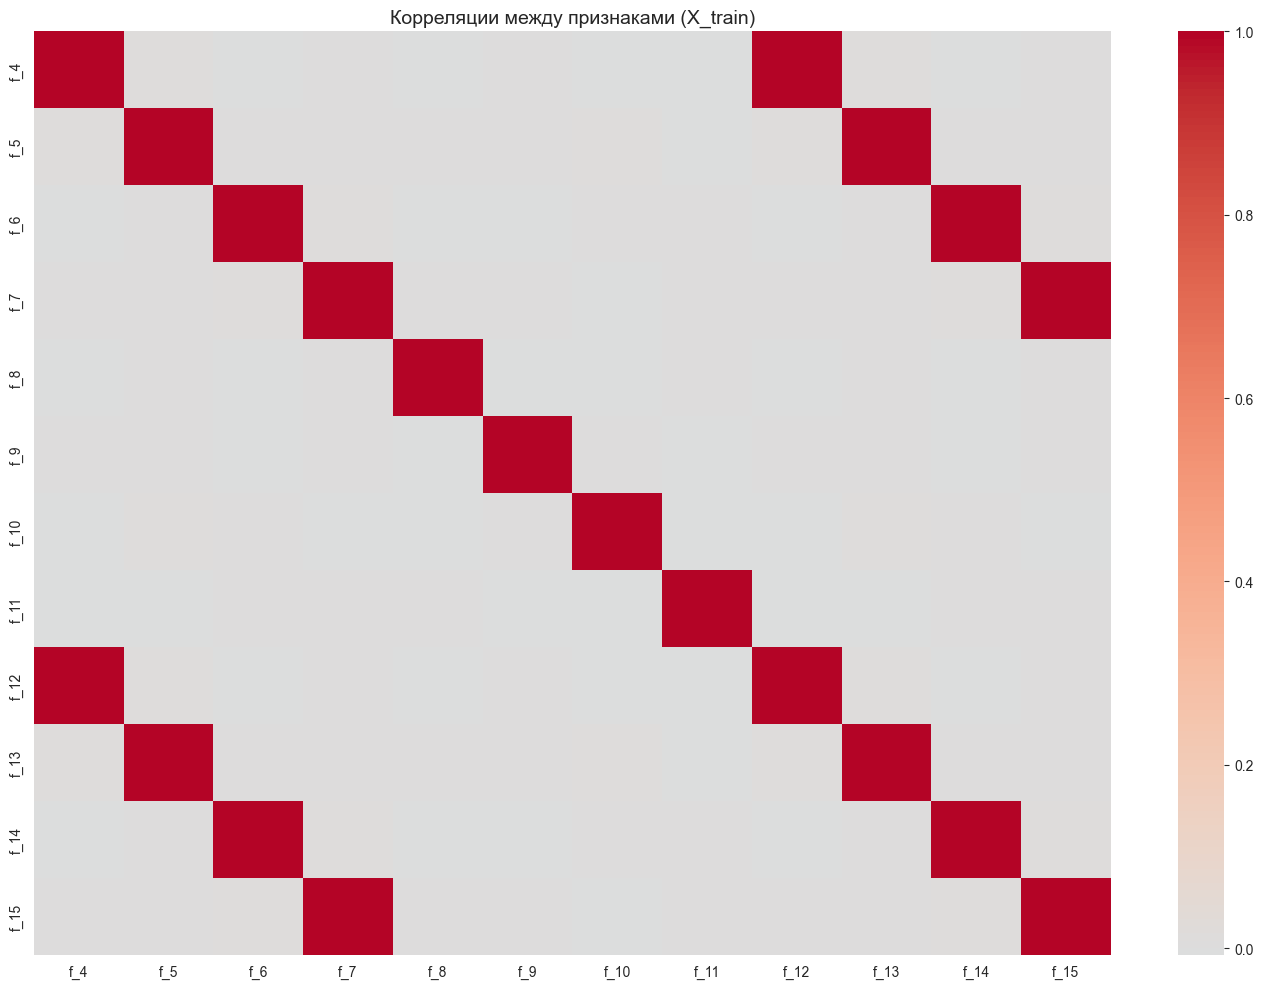

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', center=0, fmt=".2f", cbar=True)
plt.title("Корреляции между признаками (X_train)", fontsize=14)
plt.tight_layout()
plt.show()

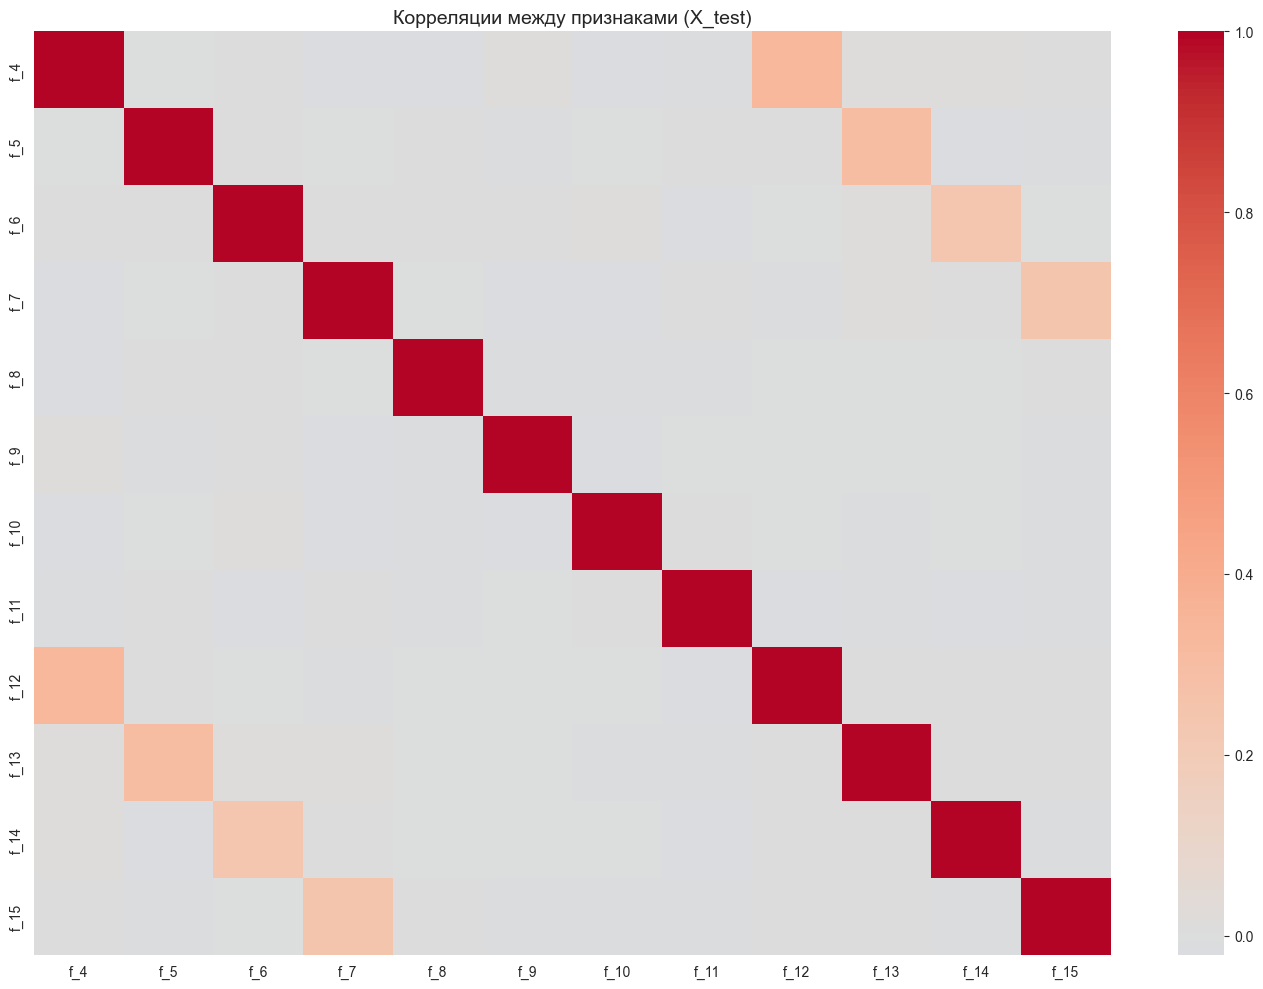

In [12]:
plt.figure(figsize=(14, 10))
sns.heatmap(X_test.corr(), annot=False, cmap='coolwarm', center=0, fmt=".2f", cbar=True)
plt.title("Корреляции между признаками (X_test)", fontsize=14)
plt.tight_layout()
plt.show()

# Поиск признаков "импостеров"

Вероятно в данных присутствует "мусор", на который модель делает большой акцент, но на самом деле это лишь особенность выборки. Давайте проверим гипотезу обучим бинарный классификатор. В действительности модель почти идеально различает $X_{train}$ и $X_{test}$. Давайте посмотрим на те признаки, которые считаются наиболее важными по мнению классификатора и удалим их (12 и 13 признаки не трогаем, т.к. понимаем, что они важны!!! Если их удалить модель "посыпется" и перестанет давать адекватные предсказания). Как только модель перестанет отличать данные, можно говорить о том, что мы нашли "те самые" признаки, которые мы хотим обобщать

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

X_all = pd.concat([X_train, X_test], ignore_index=True)
y_all = np.array([0] * len(X_train) + [1] * len(X_test))

clf = XGBClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    max_depth=3,
)
scores = cross_val_score(clf, X_all, y_all, cv=5, scoring='roc_auc')

print(f"AUC: {scores.mean():.4f}")

clf.fit(X_all, y_all)

importances = pd.Series(clf.feature_importances_, index=X_all.columns)
importances.sort_values(ascending=False).head(10)

AUC: 0.9971


f_6     0.641898
f_7     0.156977
f_12    0.071704
f_13    0.066390
f_15    0.016044
f_5     0.015598
f_4     0.014268
f_14    0.011918
f_9     0.001406
f_10    0.001341
dtype: float32

In [14]:
X_train.drop(columns=[f'f_{i + 4}' for i in range(4)], inplace=True)
X_test.drop(columns=[f'f_{i + 4}' for i in range(4)], inplace=True)

# Проверка догадки

Удалим найденные признаки "импостеры" и снова обучим классификатор. В этот раз модель уже не может отличить $X_{train}$ от $X_{test}$

In [15]:
X_all = pd.concat([X_train, X_test], ignore_index=True)
y_all = np.array([0] * len(X_train) + [1] * len(X_test))

clf = XGBClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    max_depth=3,
)
scores = cross_val_score(clf, X_all, y_all, cv=5, scoring='roc_auc')

print(f"AUC: {scores.mean():.4f}")

AUC: 0.5052


# Encoding признаков

$f_{13}$ принимает значения 0, 1, 2. Он потенциально является кандидатов в категориальные признаки. Сделаем one-hot encoding и проверим догадку. MSE падает, значит считаем догадку верной

In [16]:
X_train = pd.get_dummies(X_train, columns=['f_13'], prefix='f_13')
X_test = pd.get_dummies(X_test, columns=['f_13'], prefix='f_13')

# Обучим снова модель

Теперь обучим случайный лес и получим нашу метрику MSE < 3. Однако нужно понимать, что это метрика CV и в реальности потери будут повыше

In [17]:
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

scores = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

print("MSE по фолдам:", -scores)
print("Средний MSE:", -scores.mean())

MSE по фолдам: [1.6631661  1.76562185 1.77606217 1.72544148 1.72162211]
Средний MSE: 1.7303827417674422


# Промежуточный Результат

Посмотрим на свежую карту признаков и увидим, что теперь все оставшиеся признаки имеют значение. Однако модель можно улучшать дальше (например попробовать разбить на ансамбль по f_12 == 1 и f_12 == 0)

In [18]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

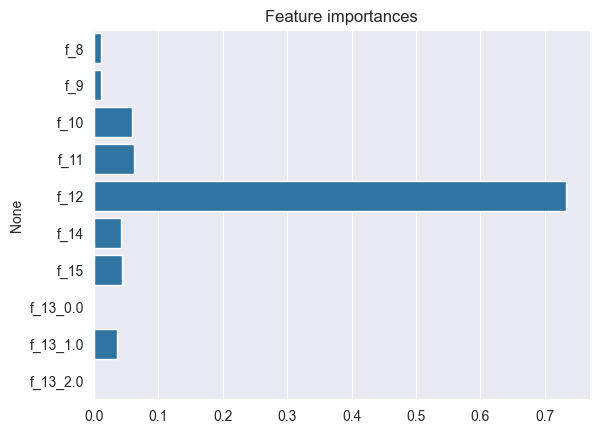

In [19]:
sns.barplot(x=model.feature_importances_, y=X_train.columns)
plt.title("Feature importances")
plt.show()

In [20]:
y_pred = model.predict(X_test)

In [21]:
submission = pd.DataFrame(y_pred, columns=['y'])
submission['ID'] = list(range(len(y_pred)))
submission.to_csv('submission.csv', sep=',', index=False)

# Новые гипотезы

Заметим, что модель очень опирается на $f_{12}$. С другой стороны, посмотрев на распределение $y$, можно заметить 2 выраженных пика. Поэтому сделаем гипотезу о том, распределение $y$ - наложение двух других распределений и $f_{12}$ выполняет роль "переключателя", указывающий из какого распределения был сэмплирован $y$.

На самом деле если сравнить y_train | f_12 == 0 и y_train | f_12 == 1 с помощью критериев из scipy.stats (или даже просто посмотрев на гистограммы) можна понять, что они по-разному распределены и имеет смысл разбить задачу на 2 подзадачи.

*p.s Для сравнения мы пробовали обучить ансамбль из 12 моделей и он справлялся примерно также как 2 XGBM (model_0 и model_1, для значений $f_{12}$ 0 и 1 соответственно), обученные на основе этой гипотезы*

In [22]:
mask_0 = X_train['f_12'] == 0
mask_1 = X_train['f_12'] == 1

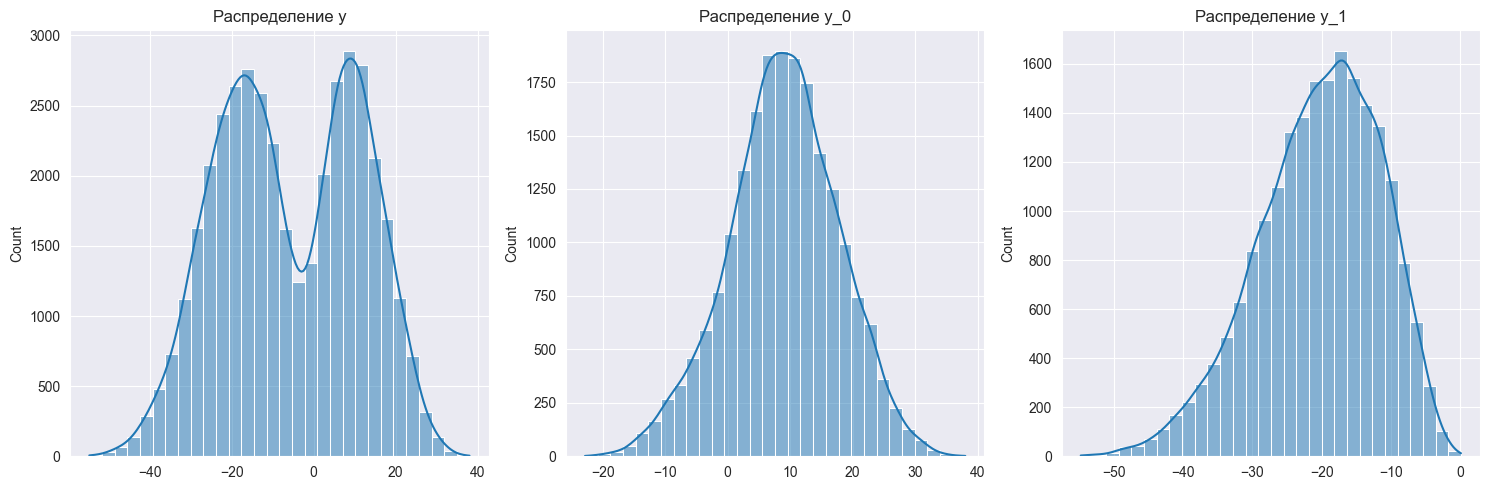

In [23]:
y = y_train
y_0 = y_train[mask_0]
y_1 = y_train[mask_1]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(y, kde=True, bins=30)
plt.title('Распределение y')

plt.subplot(1, 3, 2)
sns.histplot(y_0, kde=True, bins=30)
plt.title('Распределение y_0')

plt.subplot(1, 3, 3)
sns.histplot(y_1, kde=True, bins=30)
plt.title('Распределение y_1')

plt.tight_layout()
plt.show()

In [24]:
X_train.drop(columns='f_12', inplace=True)

# Применение ансамблей

Одна голова - хорошо, а две - лучше. Отталкиваясь от этой интуиции (и умного математического доказательства о пользе применения ансамблей) попробуем обучить свой ансамбль из 2 моделей на Метрика на кросс-валидации колеблется не сильно, так что можно считать модель +- стабильной.

В качестве основных моделей будем использовать CatBoost потому что они наши, от слоняр из Яндекса :) 

Также в оригинальной пайплайне используется поиск ГП по случайной сетке (хотя лучше бы по Optuna или Hyperopt), но здесь это упущено в целях экономии времени.


In [25]:
from catboost import CatBoostRegressor

model_0 = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)
model_1 = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)

model_0.fit(X_train[mask_0], y_train[mask_0])
model_1.fit(X_train[mask_1], y_train[mask_1])